In [1]:
# import required packages
using DifferentialEquations
using Printf
using Plots
gr()

include("../src/HHModel.jl");
# using HHModel

### Hudgkin Huxley Model


$$ C\dot{V} = I - \bar{g}_K n^4 (V-E_K) - \bar{g}_{Na} m^3 h (V - E_{Na}) - g_L (V - E_L) $$

$$ \dot{n} = \frac{n_{\infty}(V) - n}{\tau_n(V)} $$

$$ \dot{m} = \frac{m_{\infty}(V) - m}{\tau_m(V)} $$

$$ \dot{h} = \frac{h_{\infty}(V) - h}{\tau_h(V)} $$

In [9]:
## setting up biophysical parameters

# sodium channel
Na_m = HHModel.Kinetics(3, 25.0, 9.0, 0.04, 0.46, 27.0, 30.0)
Na_h = HHModel.Kinetics(1, 3.0, 7.0, 1.2, 7.4, -2.0, 20.0, state=:inactivation)
ina = HHModel.SimpleIonChannel("hh_sodium", :sodium, 120.0,
    Na_m, Na_h);

# potassium channel
K_m = HHModel.Kinetics(4, 12.0, 15.0, 1.1, 4.7, -14.0, 50.0)
ik = HHModel.SimpleIonChannel("persistent_potassium", :potassium, 36.0,
    K_m, HHModel.Kinetics());

# leakage
il = HHModel.leakage(0.3);

_model = [ina, ik, il]

## setting up stimulus function
# which takes two arguments:
# - t: as the time
# - param: a Tuple/NamedTuple of parameters

_step_stimulus = (t, param) -> begin
    (param.start < t) & (t < param.duration + param.start) ? param.step + param.holding : param.holding
end;

In [25]:
# running a current clamp simulation

# 1. create voltage clamp simulation function
_vc_sim = HHModel.VoltageClampSimulation(_model, _step_stimulus, C = 0.9, Rs = 1.0)
# for voltage clamp, series resistance is requried (default as 1.0) 

# 2. get initial values by providing starting voltage value.
u0 = HHModel.setup_init(_model, -70.0)

# 3. setup simulation time range and parameters
tspan = (0.0, 150.0)
_reversal_potential = (sodium=60.0, potassium=-90.0, leak=-80.0)
_stimulus_parameter = (start=30, duration=50, step=90.0, holding=-70.0)
sim_param = (E = _reversal_potential, stim = _stimulus_parameter)

# 4. running the simulation
prob = ODEProblem(_vc_sim, u0, tspan, sim_param)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

In [26]:
# simple visualization

# 1. get voltage and current traces
_t_preview = 20.0:0.01:120.0 # define preview time steps (sampling)
_trace = HHModel.trace_decompose(sol, _model, _t_preview, sim_param);

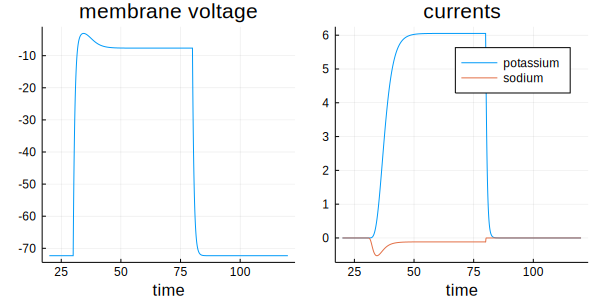

In [28]:
# 2. plot the figures
fig_a = plot(_t_preview, _trace.voltage, 
    legend=nothing, title="membrane voltage", xlabel="time")

plot(_t_preview, _trace.persistent_potassium, label="potassium")
plot!(_t_preview, _trace.hh_sodium, label="sodium")
fig_b = plot!(title="currents", xlabel="time")

plot(fig_a, fig_b, size=(600, 300))